# Predicting Vehicle Insurance Buyers from Existing Health Insurance Policy Buyers



### Business Problem
The client is an insurance company which requires a data model to predict whether existing health insurance policy holders will purchase additional Vehicle Insurance provided by the same company.

### The Data:

 **id:** Unique ID for the customer <br>
**Gender:** Gender of the customer <br>
**Age:** Age of the customer <br>
**Driving_License:** <br>
0 : Customer does not have DL <br>
1 : Customer already has DL <br>
**Region_Code:** Unique code for the region of the customer <br>
**Previously_Insured:** <br>
1 : Customer already has Vehicle Insurance <br>
0 : Customer doesn't have Vehicle Insurance <br>
**Vehicle_Age:** Age of the Vehicle <br>
**Vehicle_Damage:** <br>
1 : Customer got his/her vehicle damaged in the past. <br>
0 : Customer didn't get his/her vehicle damaged in the past. <br>
**Annual_Premium:** The amount customer needs to pay as premium in the year <br>
**PolicySalesChannel:** Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc. <br>
**Vintage:** Number of Days, Customer has been associated with the company <br>
**Response:** <br>
1 : Customer is interested <br>
0 : Customer is not interested <br>


DataSource:https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction

In [1]:
#Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,train_test_split,cross_val_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.stats import randint
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Models
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
#LightGBM is a gradient boosting framework that uses tree based learning algorithms.
from lightgbm import LGBMClassifier
#Gradient boosting on decision trees library
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#load the data
#Source of data : https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction

#Training Data
train_df = pd.read_csv('train.csv', index_col=False)

#Testing Data
test_df = pd.read_csv('test.csv',index_col=False)

#### Train Data Overview

In [3]:
#check head of train data
train_df .head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
#check head of test data
test_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


Train and test data have identical features, except that the train data has the additional response column.
Response will be the feature we are trying to predict.

In [5]:
# data overview of the train_df
print ('Rows     : ', train_df.shape[0])
print ('Columns  : ',train_df.shape[1])
print ('\nFeatures : ',train_df.columns.tolist())
print ('\nMissing values :  ',train_df.isnull().sum().values.sum())
print ('\nMissing values percentage:  ',train_df.isnull().sum().values.sum()/train_df.shape[0])
print ('\nUnique values :  \n', train_df.nunique())
print ('\nThe number of duplicate rows is:',train_df.duplicated().value_counts())
#Check for duplicates
print ('The number of duplicated rows is:',train_df.duplicated().sum())


Rows     :  381109
Columns  :  12

Features :  ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']

Missing values :   0

Missing values percentage:   0.0

Unique values :  
 id                      381109
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           48838
Policy_Sales_Channel       155
Vintage                    290
Response                     2
dtype: int64

The number of duplicate rows is: False    381109
dtype: int64
The number of duplicated rows is: 0


<AxesSubplot:>

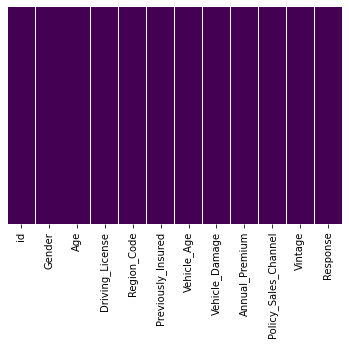

In [6]:
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [7]:
# Converting Region_Code & Policy_Sales_Channel to integer
train_df.Region_Code = train_df.Region_Code.astype('int64')
train_df.Policy_Sales_Channel = train_df.Policy_Sales_Channel.astype('int64')


test_df.Region_Code = test_df.Region_Code.astype('int64')
test_df.Policy_Sales_Channel = test_df.Policy_Sales_Channel.astype('int64')


In [8]:
train_df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  int64  
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  int64  
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 34.9+ MB


* There are 381109 insured customers and 11 variables/features containing their information.
* There are no null values  or missing values or duplicated values across the rows and columns
* Region_Code and Policy_Sales_Channel are nominal in nature
* Vintage is the count (number of days) so ordinal in nature
* Driving_License, Previously_Insured and Response have binary categories
* Age and Annual_Premium are continuous variables

#### Test Data Overview

In [10]:
# data overview of the test_df
print ('Rows     : ', test_df.shape[0])
print ('Columns  : ',test_df.shape[1])
print ('\nFeatures : ',test_df.columns.tolist())
print ('\nMissing values :  ',test_df.isnull().sum().values.sum())
print ('\nMissing values percentage:  ',test_df.isnull().sum().values.sum()/test_df.shape[0])
print ('\nUnique values :  \n', test_df.nunique())
print ('\nThe number of duplicate rows is:',test_df.duplicated().value_counts())
#Check for duplicates
print ('The number of duplicated rows is:',test_df.duplicated().sum())


Rows     :  127037
Columns  :  11

Features :  ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

Missing values :   0

Missing values percentage:   0.0

Unique values :  
 id                      127037
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           36327
Policy_Sales_Channel       145
Vintage                    290
dtype: int64

The number of duplicate rows is: False    127037
dtype: int64
The number of duplicated rows is: 0


* There are 127037 insured customers and 10 variables/features containing their information.
* There are no null values  or missing values or duplicated values across the rows and columns

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    127037 non-null  int64  
 1   Gender                127037 non-null  object 
 2   Age                   127037 non-null  int64  
 3   Driving_License       127037 non-null  int64  
 4   Region_Code           127037 non-null  int64  
 5   Previously_Insured    127037 non-null  int64  
 6   Vehicle_Age           127037 non-null  object 
 7   Vehicle_Damage        127037 non-null  object 
 8   Annual_Premium        127037 non-null  float64
 9   Policy_Sales_Channel  127037 non-null  int64  
 10  Vintage               127037 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 10.7+ MB


## Feature Overview - TrainData

### Categorical Features

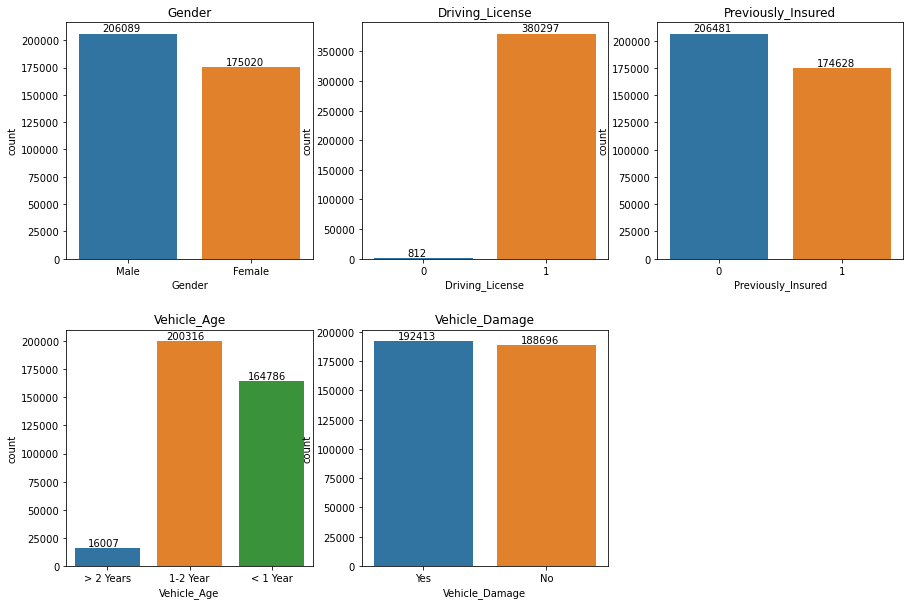

In [12]:
# Counts of Categorical variables
fig=plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace = .3, wspace=.2)
x = ['Gender','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage']
for i in range(0,len(x)):
    ax=fig.add_subplot(2,3,i+1).set_title(x[i])
    graph = sns.countplot(train_df[x[i]])
    
    for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')

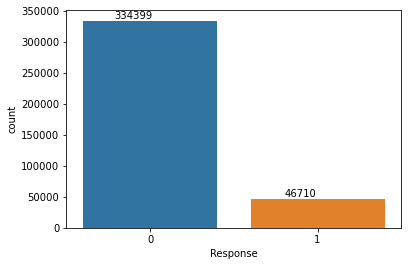

In [13]:
# Target variable count
#The response is the target feature/variable

graph = sns.countplot(train_df.Response)
for p in graph.patches:
    graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),ha='center', va='bottom',color= 'black')
    


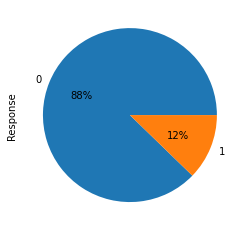

In [14]:
train_df.Response.value_counts().plot(kind='pie', autopct='%1.0f%%');

**88% of the respondents donot have vehicle insurance and 12 % have vehicle insurance**<br>
This is a biased dataset in terms of the response, as the number of responders with and without insurance is unbalanced. An up sampling or downsampling methods has to be used to train an unbiased model.The data has to be upsampled or downsampled.
- Up-sampling and Down-Sampling both have their consequences. 
- Up-Sampling will overfit as it just creates the duplicates and doesn't help the model while Down-Sampling can remove the data that can be very helpful for analysis! 
- **SMOTE** generates synthetic samples from the minority class. 
- It is used to obtain a synthetically class-balanced or nearly class-balanced training set, which is then used to train the classifier.

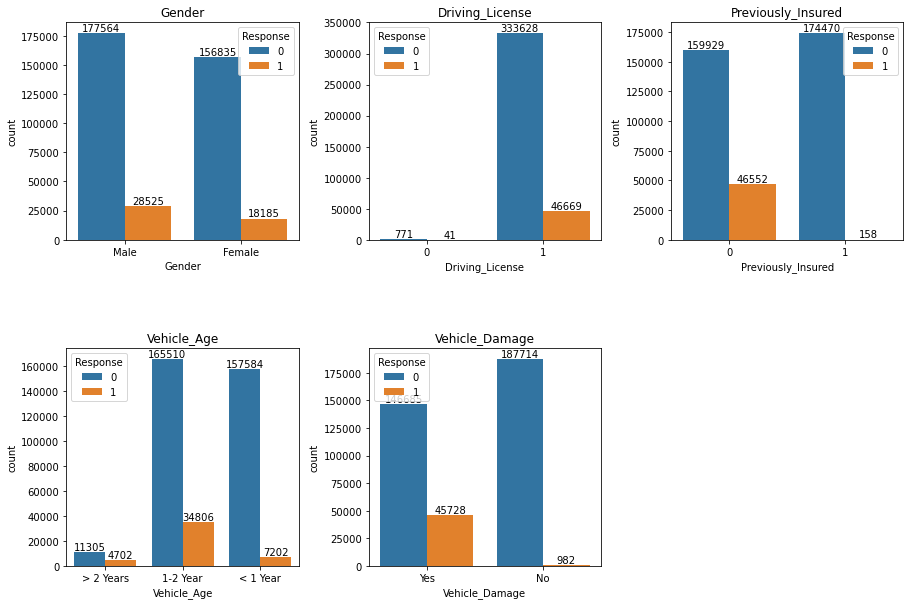

In [15]:
#Counts of Response for each categorical feature
fig=plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace = .5, wspace=.3)
x = ['Gender','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage']
for i in range(0,len(x)):
    ax=fig.add_subplot(2,3,i+1).set_title(x[i])
    graph = sns.countplot(train_df[x[i]],hue = train_df['Response'])
    
    for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')

In [16]:
print('Vehicle Damage Vs Insured:\n',pd.crosstab(train_df['Vehicle_Damage'],train_df['Previously_Insured']))
print("______________________________________")
print('Vehicle Age Vs Insured:\n',pd.crosstab(train_df['Vehicle_Age'],train_df['Previously_Insured']))
print("______________________________________")
print('Response Vs Insured:\n',pd.crosstab(train_df['Previously_Insured'],train_df['Response']))

Vehicle Damage Vs Insured:
 Previously_Insured       0       1
Vehicle_Damage                    
No                   23990  164706
Yes                 182491    9922
______________________________________
Vehicle Age Vs Insured:
 Previously_Insured       0       1
Vehicle_Age                       
1-2 Year            134991   65325
< 1 Year             55529  109257
> 2 Years            15961      46
______________________________________
Response Vs Insured:
 Response                 0      1
Previously_Insured               
0                   159929  46552
1                   174470    158


- **Gender**:There is  a similar response across both the genders.This data type can be encoded to enable better modeling.
- **Prev_Insured**: Those who already have an insurance are not interested. This was a no brainer!
Only the population without previous insurances require insurance

- **Vehicle Age**: There are 3 bins for the vehicle age. 
- less that a year
- 1 to 2 years and above 2 years
The older cars are the least insured. Cars between 1 and 2 years of age are insured the most. 
- **Vehicle_damage**:Customers who got their vehicle damaged in the past are more likely to be insured. 
- **Driving_Licence**:There are only a small number of people with no driving license. This will skew the actual model scores. 



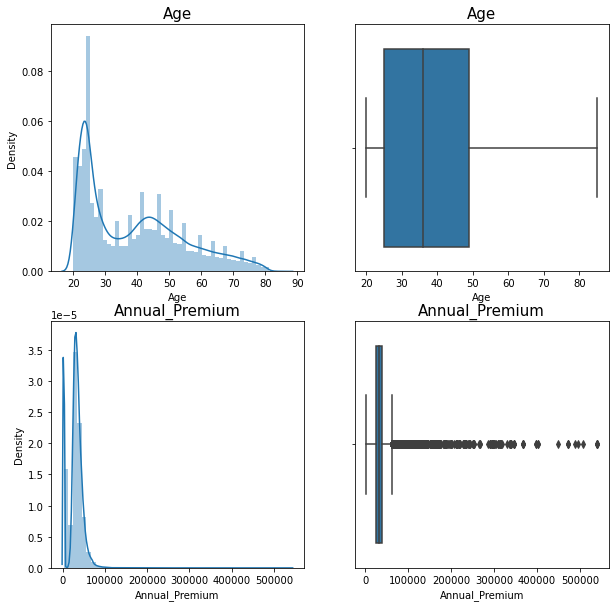

In [17]:
# Analyzing continuous variables
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(10, 10)
a = sns.distplot(train_df['Age'] , ax=axes[0][0])
a.set_title("Age",fontsize=15)
a = sns.boxplot(train_df['Age'] , orient = "v" , ax=axes[0][1])
a.set_title("Age",fontsize=15)

a = sns.distplot(train_df['Annual_Premium'] , ax=axes[1][0])
a.set_title("Annual_Premium",fontsize=15)
a = sns.boxplot(train_df['Annual_Premium'] , orient = "v" , ax=axes[1][1])
a.set_title("Annual_Premium",fontsize=15)
plt.show()

plt.show()

In [18]:
#Analyzing the response to non-categorical/continuous features


- Customer who are interested in vehicle insurance have a higher age bracket
- Annual premium for both groups are similar with people interested having slightly higher mean annual premium
- There is no significance of number of days of insurer associated with the company, their distribution is same regardless of the response

Age Distribution Of Response


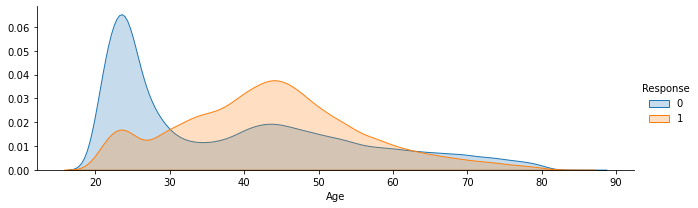

In [19]:
print("Age Distribution Of Response")
facetgrid = sns.FacetGrid(train_df,hue="Response",aspect = 3)
facetgrid.map(sns.kdeplot,"Age",shade = True)
facetgrid.set()
facetgrid.add_legend()


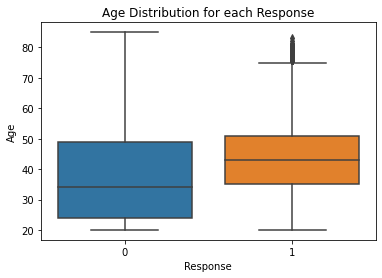

In [20]:
b = sns.boxplot(y='Age', x='Response', data=train_df);
b.set_title("Age Distribution for each Response");

Youths between 20 and 30 years of age do not have insuarance policies.This may be due to the fact that people below the age of 30 have higher premiums. It might  also be due to youngsters being less cautious, in comparison to older drivers.
In contrast, the number of insured drivers are highest between the ages  of 40 to 50. This number gradually decreases after 50. This treand might once again be due to an increase in the policy amounts  after the age of 50 or it could be due to the decrease in elderly drivers.

In [21]:
train_df['Annual_Premium'].describe()

count    381109.000000
mean      30564.389581
std       17213.155057
min        2630.000000
25%       24405.000000
50%       31669.000000
75%       39400.000000
max      540165.000000
Name: Annual_Premium, dtype: float64

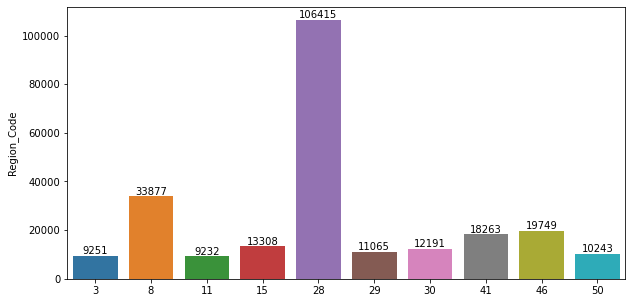

In [22]:
# Top 10 regions with highest number of insurers
labels= train_df['Region_Code'].value_counts()[:10].keys()
values= train_df['Region_Code'].value_counts()[:10]

plt.figure(figsize = (10, 5))
graph = sns.barplot(x = labels, y = values)

for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')

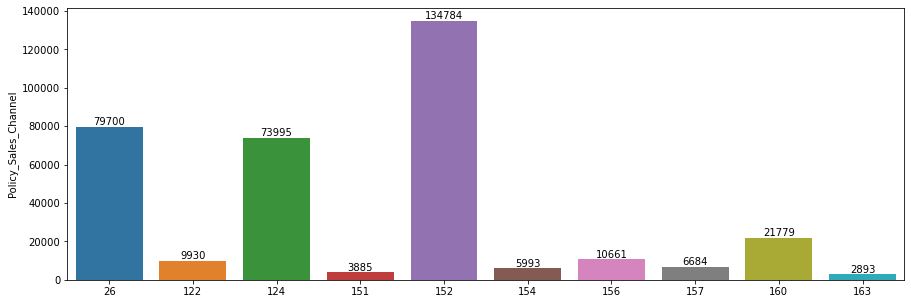

In [23]:
# Top 10 policy channels covering highest number of insurers
labels= train_df['Policy_Sales_Channel'].value_counts()[:10].keys()
values= train_df['Policy_Sales_Channel'].value_counts()[:10]

plt.figure(figsize = (15, 5))
graph = sns.barplot(x = labels, y = values)

for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')

<AxesSubplot:xlabel='Vintage', ylabel='Density'>

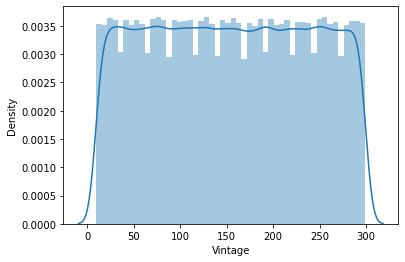

In [24]:
sns.distplot(train_df.Vintage)

### Correlation

<AxesSubplot:>

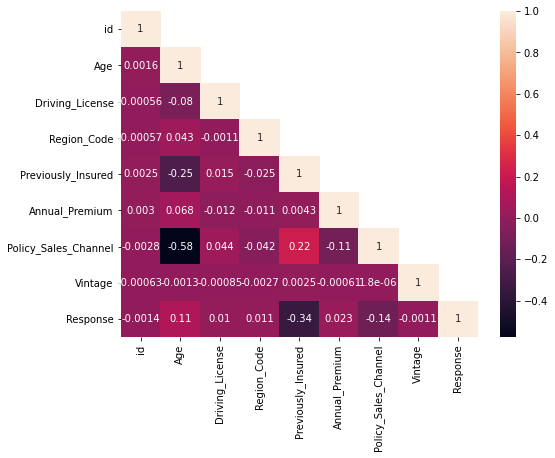

In [25]:
# Pearson Correlation
plt.figure(figsize=(8,6))
sns.heatmap(train_df.corr(),annot=True,mask=np.triu(train_df.corr(),+1))

There is not much correlation between variables except slight negative correlation between Age and Policy Sales channel.

###  Feature Engineering

In [26]:
train_df.shape

(381109, 12)

In [27]:
eda_df=train_df.copy()

In [28]:
eda_df.shape

(381109, 12)

In [29]:

#pd.categorical-Using the standard pandas Categorical constructor, we can create a category objects of non-categorical dtypes.
eda_df['Gender'] = pd.Categorical(eda_df['Gender'])
eda_df['Vehicle_Damage'] = pd.Categorical(eda_df['Vehicle_Damage'])
eda_df['Vehicle_Age'] = pd.Categorical(eda_df['Vehicle_Age'])

#Label encoding converts categorical variables to numerical representation, something that is machine-readable.
#The get_dummies() function is used to convert categorical variable into dummy/indicator variables.
eda_df = pd.concat([eda_df[['Age', 'Driving_License','Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']],
           pd.get_dummies(eda_df[['Gender', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage']])], axis=1)

In [30]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Age                    381109 non-null  int64  
 1   Driving_License        381109 non-null  int64  
 2   Annual_Premium         381109 non-null  float64
 3   Policy_Sales_Channel   381109 non-null  int64  
 4   Vintage                381109 non-null  int64  
 5   Response               381109 non-null  int64  
 6   Previously_Insured     381109 non-null  int64  
 7   Gender_Female          381109 non-null  uint8  
 8   Gender_Male            381109 non-null  uint8  
 9   Vehicle_Age_1-2 Year   381109 non-null  uint8  
 10  Vehicle_Age_< 1 Year   381109 non-null  uint8  
 11  Vehicle_Age_> 2 Years  381109 non-null  uint8  
 12  Vehicle_Damage_No      381109 non-null  uint8  
 13  Vehicle_Damage_Yes     381109 non-null  uint8  
dtypes: float64(1), int64(6), uint8(7)
me

## Feature Importance
PCA is an attractive method to decrease the number of features according to the variance they contribute. However, the method lacks transparency.
The random forest implementation of sklearn does give an output called “feature importances” which helps us explain the predictive power of the features in the dataset.

We can use the Random Forest algorithm for feature importance implemented in scikit-learn as the RandomForestRegressor and RandomForestClassifier classes.

After being fit, the model provides a feature_importances_ property that can be accessed to retrieve the relative importance scores for each input feature.

This approach can also be used with the bagging and extra trees algorithms.
Ref: https://machinelearningmastery.com/calculate-feature-importance-with-python/



In [31]:
# Copy all the predictor variables into X dataframe
X = eda_df.drop('Response', axis=1)

# Copy target into the y dataframe
y = eda_df['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=1)

In [32]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [33]:
def feature_importance(model):
    x=pd.DataFrame(model.feature_importances_*100,index=X_train.columns).sort_values(by=0,ascending=False)
    plt.figure(figsize=(12,7))
    sns.barplot(x[0],x.index,palette='rainbow')
    plt.ylabel('Feature Name')
    plt.xlabel('Feature Importance in %')
    plt.title('Feature Importance Plot')
    plt.show()

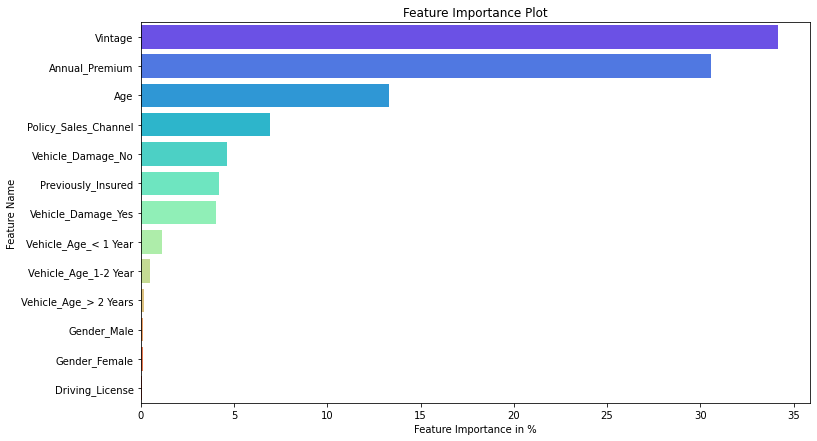

In [34]:
#plotting the featre importance
feature_importance(rf)


Driving licence is of zero feature importance and gender is of negligible importance. Thus, these 3 features can be dropped

## Outlier Treatment
If your outlier investigation during Data Exploration only finds low-frequency outliers that are likely to be erroneous, these can be treated like missing data and be either removed or replaced. The process of removing outliers from your data set is referred to as trimming or truncation.
If you believe important information will be lost by removing or changing outlier values, you may wish to keep them and use a machine learning algorithm and optimization metric robust to outliers.
Outliers can be replaced by techniques similar to missing data, e.g. with mean, mode or median. More complicated techniques include Winsorizing — replacing extreme values with minimum and maximum percentiles — and discretization (binning) — dividing the continuous variable into discrete groups.
ref:https://towardsdatascience.com/data-preparation-for-machine-learning-cleansing-transformation-feature-engineering-d2334079b06d

In [35]:
outlier_df=train_df.copy()

In [36]:
Q1 = outlier_df['Annual_Premium'].quantile(0.25)
Q3 = outlier_df['Annual_Premium'].quantile(0.75)
IQR = Q3 - Q1
lower_range= Q1-(3 * IQR)
upper_range= Q3+(3 * IQR)
print('Number of Outliers:')
((outlier_df['Annual_Premium'] < (lower_range)) | (outlier_df['Annual_Premium'] > (upper_range))).sum()

Number of Outliers:


1837

In [37]:
((((outlier_df['Annual_Premium'] < (lower_range)) | (outlier_df['Annual_Premium'] > (upper_range))).sum())/outlier_df.shape[0])*100

0.482014331857815

In [38]:
print('Upper Range: {}\nLower Range:{}'.format(upper_range,lower_range))

Upper Range: 84385.0
Lower Range:-20580.0


In [39]:
outlier_df['Annual_Premium']=np.where(outlier_df['Annual_Premium']>upper_range,upper_range,outlier_df['Annual_Premium'])
outlier_df['Annual_Premium']=np.where(outlier_df['Annual_Premium']<lower_range,lower_range,outlier_df['Annual_Premium'])

<AxesSubplot:xlabel='Annual_Premium'>

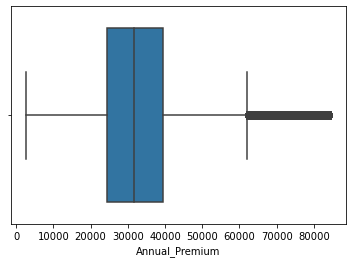

In [40]:
sns.boxplot(outlier_df['Annual_Premium'])

<AxesSubplot:xlabel='Annual_Premium', ylabel='Density'>

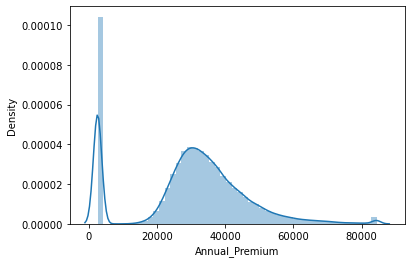

In [41]:
sns.distplot(outlier_df['Annual_Premium'])

In [42]:
Q1 = test_df['Annual_Premium'].quantile(0.25)
Q3 = test_df['Annual_Premium'].quantile(0.75)
IQR = Q3 - Q1
lower_range= Q1-(3 * IQR)
upper_range= Q3+(3 * IQR)
print('Number of Outliers:')
((test_df['Annual_Premium'] < (lower_range)) | (test_df['Annual_Premium'] > (upper_range))).sum()

Number of Outliers:


586

In [43]:
test_df['Annual_Premium']=np.where(test_df['Annual_Premium']>upper_range,upper_range,test_df['Annual_Premium'])
test_df['Annual_Premium']=np.where(test_df['Annual_Premium']<lower_range,lower_range,test_df['Annual_Premium'])

## Data Transformation
It is rare to have collected data solely to make predictions. Consequently, the data you have available may not be in the right format or may require transformations to make it more useful. Data Transformation activities and techniques include:
* Categorical encoding
* Dealing with skewed data
* Bias mitigation
* Scaling
* Rank transformation
* Power functions

**Age and annual premium highly skewed. Not normally distributed. Both right skewed with non negative values.**
Normality is often assumed with statistical techniques; if you’re using regression algorithms such as linear regression or neural networks, you are likely to see large improvements if you transform variables with skewed distributions.
To approximate a more symmetric distribution, you can use roots (i.e. square-root, cube root), logarithms (i.e. base e, or base 10), reciprocals (i.e. positive or negative), or Box-Cox transformation.
https://towardsdatascience.com/data-preparation-for-machine-learning-cleansing-transformation-feature-engineering-d2334079b06d

In [44]:
# a function to view the frequency distribution 
# probplot  calculates a best-fit line for the data and plots the results using the given plot function.
#QQ plots are really nifty  to visualize whether something is normally distributed. 

def diagnostic_plots(X,var):
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.title(var)
    X.hist()

    plt.subplot(1, 2, 2)
    stats.probplot(X, dist="norm", plot=plt)

    plt.show()
def box_plots(X,Y,var1,var2):
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.title(var1)
    sns.boxplot(X)

    plt.subplot(1, 2, 2)
    plt.title(var2)
    sns.boxplot(Y)

    plt.show()

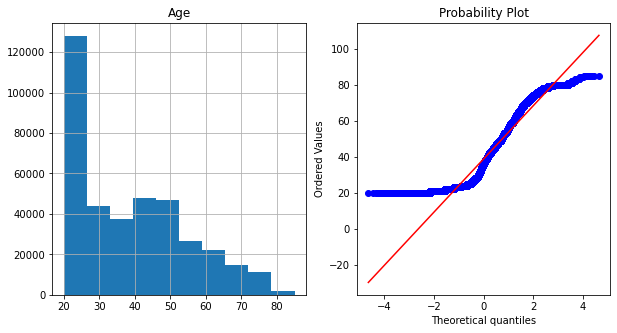

Skewness for Age : 0.6725389977260843
---------------------------------------------------------------------------------------------------


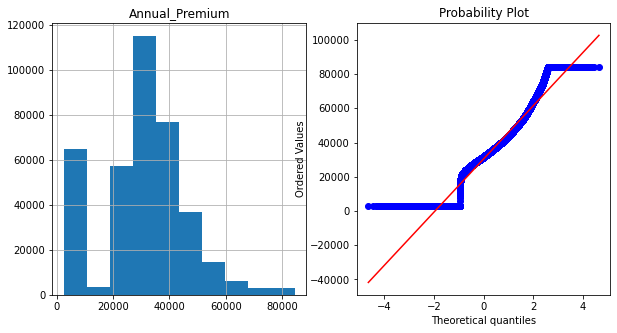

Skewness for Annual_Premium : -0.05098997333278524
---------------------------------------------------------------------------------------------------


In [45]:
for i in ['Age','Annual_Premium']:
    diagnostic_plots(outlier_df[i],i)
    print('Skewness for',i,":",outlier_df[i].skew())
    print('---------------------------------------------------------------------------------------------------')

### LOG Transformation

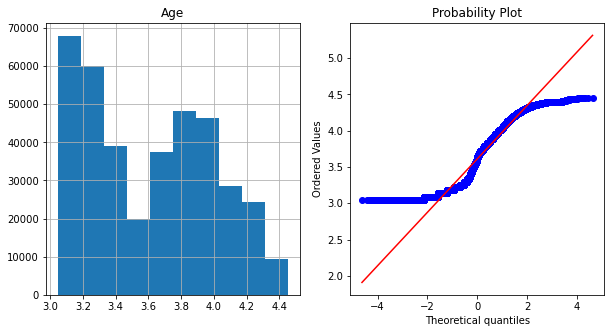

Skewness for Age : 0.21519459748016914


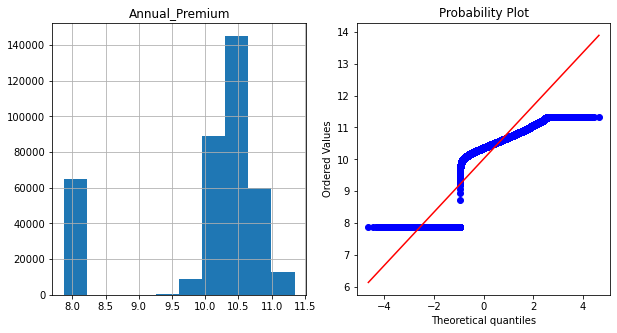

Skewness for Annual_Premium : -1.4854133308371857


In [46]:
for i in ['Age','Annual_Premium']:
    diagnostic_plots(np.log(outlier_df[i]+1),i)
    print('Skewness for',i,":",np.log(outlier_df[i]+1).skew())

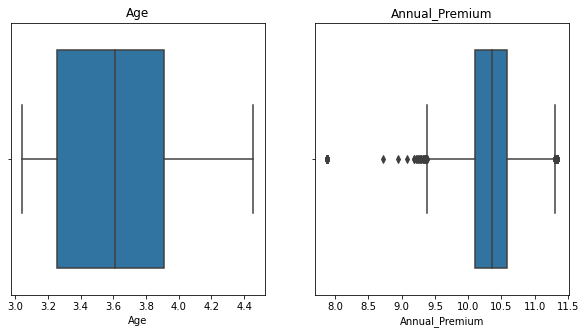

In [47]:
box_plots(np.log(outlier_df['Age']+1),np.log(outlier_df['Annual_Premium']+1),'Age','Annual_Premium')

### Square Root Transformation

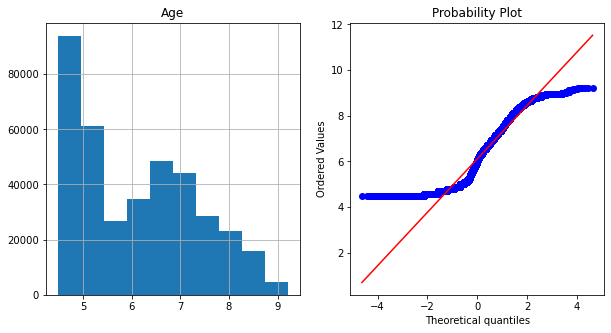

Skewness for Age : 0.4260612364434474


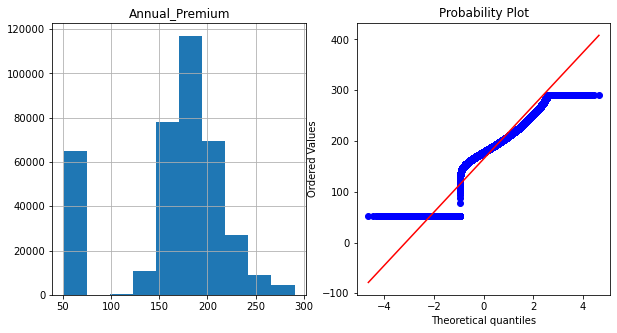

Skewness for Annual_Premium : -0.9546883756147109


In [48]:
for i in ['Age','Annual_Premium']:
    diagnostic_plots(outlier_df[i]**(1/2),i)
    print('Skewness for',i,":",(outlier_df[i]**(1/2)).skew())

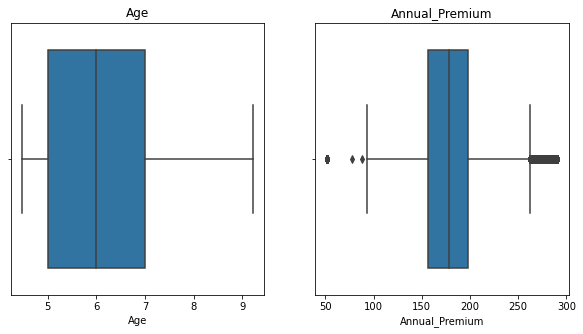

In [49]:
box_plots(outlier_df['Age']**(1/2),outlier_df['Annual_Premium']**(1/2),'Age','Annual_Premium')

### Cube Root Transformation

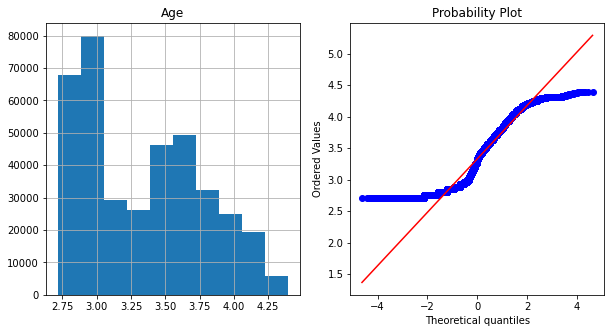

Skewness for Age : 0.34936955994159585


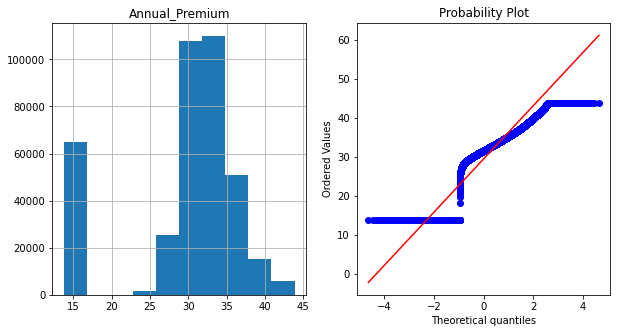

Skewness for Annual_Premium : -1.1770339689869331


In [50]:
for i in ['Age','Annual_Premium']:
    diagnostic_plots(outlier_df[i]**(1/3),i)
    print('Skewness for',i,":",(outlier_df[i]**(1/3)).skew())

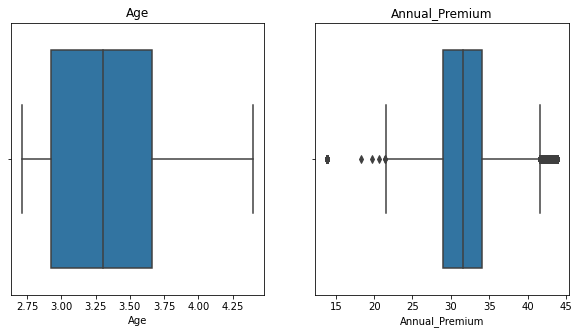

In [51]:
box_plots(outlier_df['Age']**(1/3),outlier_df['Annual_Premium']**(1/3),'Age','Annual_Premium')

### Reciprocal Transformation

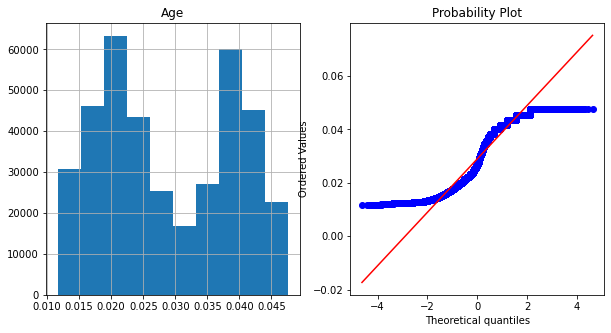

Skewness for Age : 0.14868262815842606


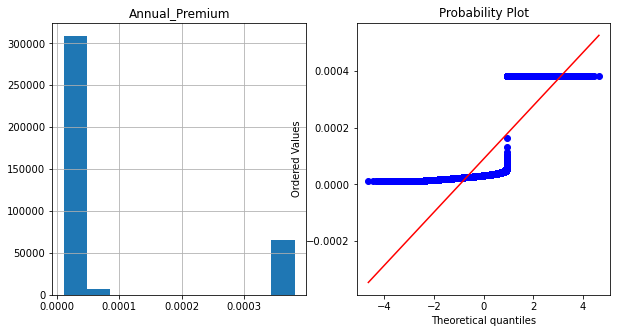

Skewness for Annual_Premium : 1.7415154543067046


In [52]:
for i in ['Age','Annual_Premium']:
    diagnostic_plots(1/(outlier_df[i]+1),i)
    print('Skewness for',i,":",(1/(outlier_df[i]+1)).skew())


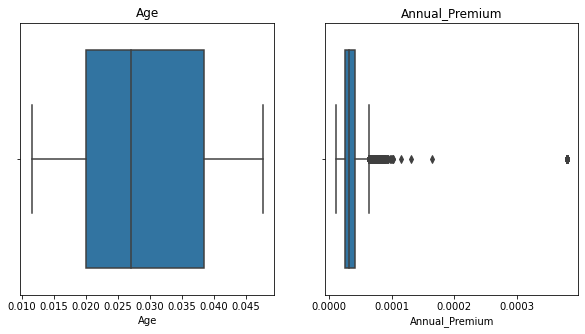

In [53]:
box_plots(1/(outlier_df['Age']+1),1/(outlier_df['Annual_Premium']+1),'Age','Annual_Premium')

### BoxCox Transformation

In [54]:
outlier_df['Age_boxcox'], param = stats.boxcox(outlier_df.Age) 
outlier_df['Annual_Premium_boxcox'], param = stats.boxcox(outlier_df.Annual_Premium)

In [55]:
test_df['Age_boxcox'], param = stats.boxcox(test_df.Age) 
test_df['Annual_Premium_boxcox'], param = stats.boxcox(test_df.Annual_Premium) 

In [56]:
train_df['Age_boxcox'], param = stats.boxcox(train_df.Age) 
train_df['Annual_Premium_boxcox'], param = stats.boxcox(train_df.Annual_Premium) 

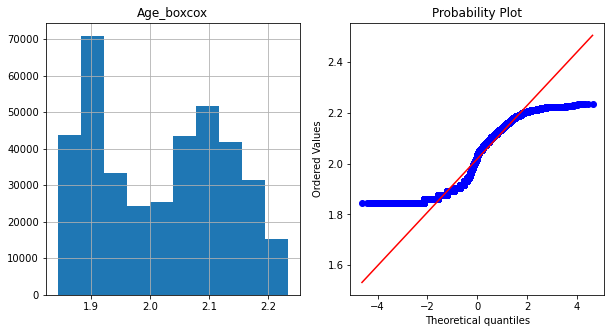

Skewness for Age_boxcox : 0.062216134539466915


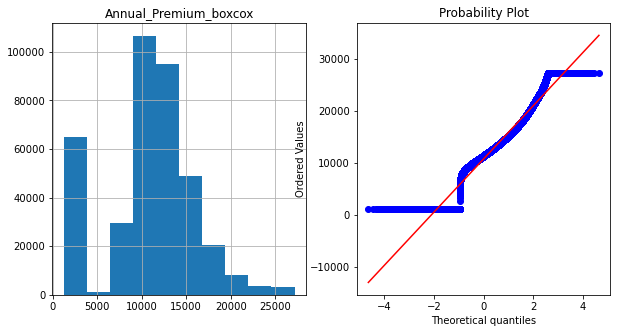

Skewness for Annual_Premium_boxcox : -0.27342263435221464


In [57]:
for i in ['Age_boxcox','Annual_Premium_boxcox']:
    diagnostic_plots(outlier_df[i],i)
    print('Skewness for',i,":",outlier_df[i].skew())

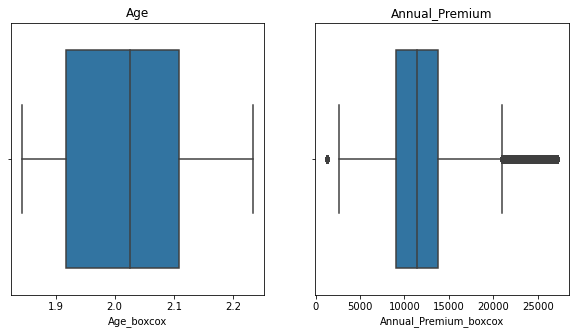

In [58]:
box_plots(outlier_df['Age_boxcox'],outlier_df['Annual_Premium_boxcox'],'Age','Annual_Premium')

In [59]:
outlier_df.drop(['id','Age','Annual_Premium','Driving_License'],axis=1,inplace=True)

In [60]:
test_df.drop(['id','Age','Annual_Premium','Driving_License'],axis=1,inplace=True)

In [61]:
train_df.drop(['id','Age','Annual_Premium','Driving_License'],axis=1,inplace=True)

In [62]:
outlier_df.shape

(381109, 10)

In [63]:
train_df.shape

(381109, 10)

In [64]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Gender                 381109 non-null  object 
 1   Region_Code            381109 non-null  int64  
 2   Previously_Insured     381109 non-null  int64  
 3   Vehicle_Age            381109 non-null  object 
 4   Vehicle_Damage         381109 non-null  object 
 5   Policy_Sales_Channel   381109 non-null  int64  
 6   Vintage                381109 non-null  int64  
 7   Response               381109 non-null  int64  
 8   Age_boxcox             381109 non-null  float64
 9   Annual_Premium_boxcox  381109 non-null  float64
dtypes: float64(2), int64(5), object(3)
memory usage: 29.1+ MB


In [65]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Gender                 127037 non-null  object 
 1   Region_Code            127037 non-null  int64  
 2   Previously_Insured     127037 non-null  int64  
 3   Vehicle_Age            127037 non-null  object 
 4   Vehicle_Damage         127037 non-null  object 
 5   Policy_Sales_Channel   127037 non-null  int64  
 6   Vintage                127037 non-null  int64  
 7   Age_boxcox             127037 non-null  float64
 8   Annual_Premium_boxcox  127037 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 8.7+ MB


In [66]:
test_df.shape

(127037, 9)

### Encoding

In [67]:
#Label Encoding less than 1 year as 0, 1-2 years as 1 and above 2 years 2
train_df.replace({'< 1 Year': 0,'1-2 Year': 1,'> 2 Years': 2},inplace=True)

In [68]:
test_df.replace({'< 1 Year': 0,'1-2 Year': 1,'> 2 Years': 2},inplace=True)

In [69]:
# dummy variable encoding
train_df = pd.get_dummies(train_df, columns=['Gender','Vehicle_Damage'],drop_first=True)

In [70]:
test_df = pd.get_dummies(test_df, columns=['Gender','Vehicle_Damage'],drop_first=True)

In [71]:
train_df.head()

,Region_Code,Previously_Insured,Vehicle_Age,Policy_Sales_Channel,Vintage,Response,Age_boxcox,Annual_Premium_boxcox,Gender_Male,Vehicle_Damage_Yes
0,28,0,2,26,217,1,2.080704,4449.430679,1,1
1,3,0,1,26,183,0,2.210159,3853.175084,1,0
2,28,0,2,26,27,1,2.097693,4266.017588,1,1
3,11,1,0,152,203,0,1.860233,3411.865432,1,0
4,41,1,0,152,39,0,1.963597,3308.672774,0,0


<AxesSubplot:>

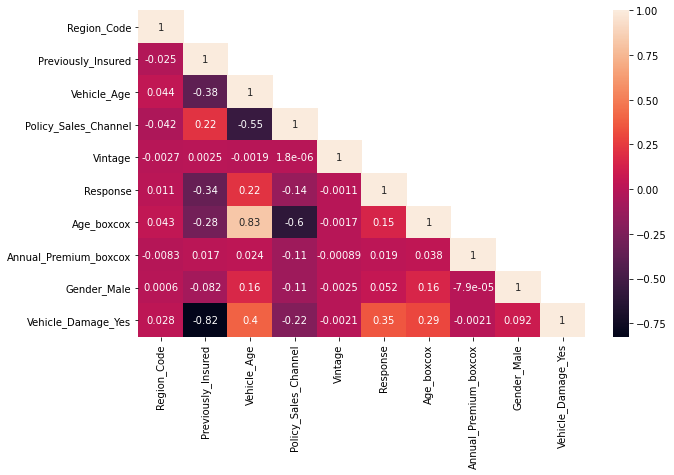

In [72]:
# Pearson Correlation
plt.figure(figsize=(10,6))
sns.heatmap(train_df.corr(),annot=True,mask=np.triu(train_df.corr(),+1))

* A strong positive correlation exists between Vehicle age and age
* A strong negative correlation exists between Vehicle damage and previously insured

### Multicollinearity and VIF
Multicollinearity occurs when two or more independent variables are highly correlated with one another in a regression model.
* VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable. 
or
* VIF score of an independent variable represents how well the variable is explained by other independent variables.

In [73]:
# Checking level of multicollinearity with VIF of all variables
X = train_df.drop('Response', axis=1)
vif = [variance_inflation_factor(X.values, ix) for ix in range(X.shape[1])] 
i=0
for column in X.columns:
  print (column ,"--->",  vif[i])
  i = i+1

Region_Code ---> 4.978938293446108
Previously_Insured ---> 5.791972055997727
Vehicle_Age ---> 4.176576682510433
Policy_Sales_Channel ---> 7.122582189247431
Vintage ---> 4.3900329696812745
Age_boxcox ---> 37.40741640175694
Annual_Premium_boxcox ---> 5.639474953049554
Gender_Male ---> 2.2429580640247697
Vehicle_Damage_Yes ---> 6.388265426162193


In [74]:
train_df.drop('Age_boxcox',axis=1,inplace=True)

In [75]:
test_df.drop('Age_boxcox',axis=1,inplace=True)

In [76]:
X = train_df.drop('Response', axis=1)
vif = [variance_inflation_factor(X.values, ix) for ix in range(X.shape[1])] 
i=0
for column in X.columns:
  print (column ,"--->",  vif[i])
  i = i+1

Region_Code ---> 4.426622447183734
Previously_Insured ---> 4.342881567617384
Vehicle_Age ---> 2.9764302242814398
Policy_Sales_Channel ---> 5.166606982590024
Vintage ---> 3.9928217564556427
Annual_Premium_boxcox ---> 4.76685192976767
Gender_Male ---> 2.176213999347086
Vehicle_Damage_Yes ---> 5.07279270881498


Now the values are around 5 which is acceptable hence we will proceed with the remaining variables

In [77]:
print("Unique values in Policy_Sales_Channel: {}\nUnique values in Region_Code: {}".format(train_df.Policy_Sales_Channel.nunique(),train_df.Region_Code.nunique()))

Unique values in Policy_Sales_Channel: 155
Unique values in Region_Code: 53


#### Mean Encoding

In [78]:
## Mean encoding for Policy_Sales_Channel and Region_Code
df_mean_encode = train_df

In [79]:
encod_type_Region_Code = df_mean_encode.groupby('Region_Code')['Response'].mean()
encod_type_Policy_Sales_Channel = df_mean_encode.groupby('Policy_Sales_Channel')['Response'].mean()

In [80]:
df_mean_encode.loc[:, 'Region_Code'] = df_mean_encode['Region_Code'].map(encod_type_Region_Code)
df_mean_encode.loc[:, 'Policy_Sales_Channel'] = df_mean_encode['Policy_Sales_Channel'].map(encod_type_Policy_Sales_Channel)

In [81]:
test_df.loc[:, 'Region_Code'] = test_df['Region_Code'].map(encod_type_Region_Code)
test_df.loc[:, 'Policy_Sales_Channel'] = test_df['Policy_Sales_Channel'].map(encod_type_Policy_Sales_Channel)

In [82]:
df_mean_encode.head() 

,Region_Code,Previously_Insured,Vehicle_Age,Policy_Sales_Channel,Vintage,Response,Annual_Premium_boxcox,Gender_Male,Vehicle_Damage_Yes
0,0.187163,0,2,0.199385,217,1,4449.430679,1,1
1,0.127662,0,1,0.199385,183,0,3853.175084,1,0
2,0.187163,0,2,0.199385,27,1,4266.017588,1,1
3,0.112760,1,0,0.028624,203,0,3411.865432,1,0
4,0.121776,1,0,0.028624,39,0,3308.672774,0,0


In [83]:
test_df.head()

,Region_Code,Previously_Insured,Vehicle_Age,Policy_Sales_Channel,Vintage,Annual_Premium_boxcox,Gender_Male,Vehicle_Damage_Yes
0,0.112760,1,0,0.028624,53,12518.854580,1,0
1,0.187163,0,1,0.113892,111,11887.622945,1,1
2,0.187163,0,1,0.189148,199,13835.981119,1,1
3,0.074035,1,0,0.028624,187,13005.750481,1,1
4,0.187163,1,0,0.028624,297,19550.405115,1,0


#### Frequency Encoding

In [84]:
## Frequency encoding for Policy_Sales_Channel and Region_Code
df_frequency_encode = train_df

In [85]:
df_frequency_map_region = df_frequency_encode.Region_Code.value_counts().to_dict()
df_frequency_map_Policy_Sales_Channel = df_frequency_encode.Policy_Sales_Channel.value_counts().to_dict()

In [86]:
df_frequency_encode['Region_Code'] = df_frequency_encode['Region_Code'].map(df_frequency_map_region)
df_frequency_encode['Policy_Sales_Channel'] = df_frequency_encode['Policy_Sales_Channel'].map(df_frequency_map_Policy_Sales_Channel)

In [87]:
df_frequency_encode.head()

,Region_Code,Previously_Insured,Vehicle_Age,Policy_Sales_Channel,Vintage,Response,Annual_Premium_boxcox,Gender_Male,Vehicle_Damage_Yes
0,106415,0,2,79700,217,1,4449.430679,1,1
1,9251,0,1,79700,183,0,3853.175084,1,0
2,106415,0,2,79700,27,1,4266.017588,1,1
3,9232,1,0,134784,203,0,3411.865432,1,0
4,18263,1,0,134784,39,0,3308.672774,0,0


#### KDD Encoding
One hot encoding only the top 10 categories of Policy_Sales_Channel and Region_Code

In [88]:
## KDD encoding for Policy_Sales_Channel and Region_Code
df_KDD_encode = train_df

In [89]:
# function to create the dummy variables for the most frequent labels
# we can vary the number of most frequent labels that we encode
def one_hot_encoding_top_x(df, variable, x):
    
    top_x_labels = [y for y in df[variable].value_counts().sort_values(ascending=False).head(x).index]
    
    for label in top_x_labels:
        df[variable+'_'+str(label)] = np.where(df[variable]==label, 1, 0)


In [90]:
one_hot_encoding_top_x(df_KDD_encode, 'Region_Code', 10)
one_hot_encoding_top_x(df_KDD_encode, 'Policy_Sales_Channel', 10)

In [91]:
df_KDD_encode.drop(['Region_Code','Policy_Sales_Channel'],axis=1,inplace=True)

In [92]:
df_KDD_encode.head()

,Previously_Insured,Vehicle_Age,Vintage,Response,Annual_Premium_boxcox,Gender_Male,Vehicle_Damage_Yes,Region_Code_106415,Region_Code_33877,Region_Code_19749,...,Policy_Sales_Channel_134784,Policy_Sales_Channel_79700,Policy_Sales_Channel_73995,Policy_Sales_Channel_21779,Policy_Sales_Channel_10661,Policy_Sales_Channel_9930,Policy_Sales_Channel_6684,Policy_Sales_Channel_5993,Policy_Sales_Channel_3885,Policy_Sales_Channel_2893
0,0,2,217,1,4449.430679,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,1,183,0,3853.175084,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,2,27,1,4266.017588,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,0,203,0,3411.865432,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1,0,39,0,3308.672774,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### Splitting and Scaling the Data

Im going to scale and split all three types of encoded data and compare the accuracies of the models.
* df_mean_encode
* df_frequency_encode
* df_KDD_encode
A MinMax Scaler will be used for scaling the data

In [93]:
#function to scale the data
mm = MinMaxScaler()
def split_data(dataframe):
    # Copy all the predictor variables into X dataframe
    X = dataframe.drop('Response', axis=1)
    
    # Copy target into the y dataframe
    y = dataframe['Response']
    
    # Split X and y into training and test set in 70:30 ratio
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=1)
    
    # Transform data using MinMaxScaler
    X_trains = mm.fit_transform(X_train)
    X_tests = mm.transform(X_test)
    return X_trains,X_tests,y_train,y_test

### Building Models
Models :

* Naive Bayes (as benchmark)
* Decision Tree
* Random Forest
* Logistic Regression
* LDA
* XGBoost
* LightGBM
First building the models without any hyperparameters to check impact of encoding results on different models.

#### Mean Encoded Models

In [94]:
X_trains,X_tests,y_train,y_test = split_data(df_mean_encode);

In [95]:


results_mean_encode = pd.DataFrame({'accuracy_train':[],'accuracy_test':[],'f1_score_train':[],'f1_score_test': [],
                                    'recall_train': [], 'recall_test': [],'precision_train': [],'precision_test': [],
                                    'AUC_train': [],'AUC_test': []})
models = [GaussianNB(), 
          DecisionTreeClassifier(random_state=1), 
          RandomForestClassifier(random_state=1), 
          LogisticRegression(random_state = 1), 
          LinearDiscriminantAnalysis(), 
          xgb.XGBClassifier(random_state=1), 
          LGBMClassifier(random_state=1)]

In [96]:
for model in models:
    model.fit(X_trains, y_train)
    results_mean_encode = results_mean_encode.append({'accuracy_train':metrics.accuracy_score(y_train, model.predict(X_trains)),
                                                      'accuracy_test': metrics.accuracy_score(y_test, model.predict(X_tests)),
                                                      'f1_score_train': metrics.f1_score(y_train, model.predict(X_trains)),
                                                      'f1_score_test': metrics.f1_score(y_test, model.predict(X_tests)),
                                                      'recall_train': metrics.recall_score(y_train, model.predict(X_trains)), 
                                                      'recall_test': metrics.recall_score(y_test, model.predict(X_tests)),
                                                      'precision_train': metrics.precision_score(y_train, model.predict(X_trains)),
                                                      'precision_test': metrics.precision_score(y_test, model.predict(X_tests)),
                                                      'AUC_train': roc_auc_score(y_train,model.predict_proba(X_trains)[:,1]),
                                                      'AUC_test': roc_auc_score(y_test,model.predict_proba(X_tests)[:,1])
                                                     }, ignore_index=True)
    
results_mean_encode['Models'] = ['Naive Bayes','Decision Tree','Random Forest','Logistic Regression','LDA','XGBoost','LightGBM']
results_mean_encode

,accuracy_train,accuracy_test,f1_score_train,f1_score_test,recall_train,recall_test,precision_train,precision_test,AUC_train,AUC_test,Models
0,0.721958,0.722539,0.432231,0.428198,0.858463,0.859417,0.288827,0.285131,0.824116,0.824614,Naive Bayes
1,0.990097,0.825466,0.958450,0.274917,0.926510,0.273714,0.992670,0.276131,0.999418,0.600847,Decision Tree
2,0.990044,0.851347,0.958650,0.215183,0.936118,0.168584,0.982293,0.297384,0.998516,0.800216,Random Forest
3,0.876713,0.879116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.835036,0.834963,Logistic Regression
4,0.876706,0.878968,0.003876,0.003170,0.001946,0.001592,0.488550,0.360656,0.833401,0.833428,LDA
5,0.879240,0.878548,0.051410,0.021699,0.026544,0.011142,0.813607,0.412869,0.868890,0.837679,XGBoost
6,0.876799,0.878758,0.003275,0.000721,0.001642,0.000362,0.627907,0.098039,0.846515,0.839918,LightGBM


### Frequency Encoded Models

In [97]:
X_trains,X_tests,y_train,y_test = split_data(df_frequency_encode);

In [98]:
results_frequency_encode = pd.DataFrame({'accuracy_train':[],'accuracy_test':[],'f1_score_train':[],'f1_score_test': [],
                                         'recall_train': [], 'recall_test': [],'precision_train': [],'precision_test': [],
                                         'AUC_train': [],'AUC_test': []})

In [99]:
for model in models:
    model.fit(X_trains, y_train)
    results_frequency_encode = results_frequency_encode.append({'accuracy_train':metrics.accuracy_score(y_train, model.predict(X_trains)),
                                                                'accuracy_test': metrics.accuracy_score(y_test, model.predict(X_tests)),
                                                                'f1_score_train': metrics.f1_score(y_train, model.predict(X_trains)),
                                                                'f1_score_test': metrics.f1_score(y_test, model.predict(X_tests)),
                                                                'recall_train': metrics.recall_score(y_train, model.predict(X_trains)), 
                                                                'recall_test': metrics.recall_score(y_test, model.predict(X_tests)),
                                                                'precision_train': metrics.precision_score(y_train, model.predict(X_trains)),
                                                                'precision_test': metrics.precision_score(y_test, model.predict(X_tests)),
                                                                'AUC_train': roc_auc_score(y_train,model.predict_proba(X_trains)[:,1]),
                                                                'AUC_test': roc_auc_score(y_test,model.predict_proba(X_tests)[:,1])
                                                               }, ignore_index=True)
    
results_frequency_encode['Models'] = ['Naive Bayes','Decision Tree','Random Forest','Logistic Regression','LDA','XGBoost','LightGBM']
results_frequency_encode

,accuracy_train,accuracy_test,f1_score_train,f1_score_test,recall_train,recall_test,precision_train,precision_test,AUC_train,AUC_test,Models
0,0.721958,0.722539,0.432231,0.428198,0.858463,0.859417,0.288827,0.285131,0.824116,0.824614,Naive Bayes
1,0.990097,0.825466,0.958450,0.274917,0.926510,0.273714,0.992670,0.276131,0.999418,0.600847,Decision Tree
2,0.990044,0.851347,0.958650,0.215183,0.936118,0.168584,0.982293,0.297384,0.998516,0.800216,Random Forest
3,0.876713,0.879116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.835036,0.834963,Logistic Regression
4,0.876706,0.878968,0.003876,0.003170,0.001946,0.001592,0.488550,0.360656,0.833401,0.833428,LDA
5,0.879240,0.878548,0.051410,0.021699,0.026544,0.011142,0.813607,0.412869,0.868890,0.837679,XGBoost
6,0.876799,0.878758,0.003275,0.000721,0.001642,0.000362,0.627907,0.098039,0.846515,0.839918,LightGBM


#### KDD Encoded Models

In [100]:
#KDD Encoding
X_trains,X_tests,y_train,y_test = split_data(df_KDD_encode);

In [101]:
results_KDD_encode = pd.DataFrame({'accuracy_train':[],'accuracy_test':[],'f1_score_train':[],'f1_score_test': [],
                                   'recall_train': [], 'recall_test': [],'precision_train': [],'precision_test': [],
                                   'AUC_train': [],'AUC_test': []})

In [102]:
for model in models:
    model.fit(X_trains, y_train)
    results_KDD_encode = results_KDD_encode.append({'accuracy_train':metrics.accuracy_score(y_train, model.predict(X_trains)),
                                                    'accuracy_test': metrics.accuracy_score(y_test, model.predict(X_tests)),
                                                    'f1_score_train': metrics.f1_score(y_train, model.predict(X_trains)),
                                                    'f1_score_test': metrics.f1_score(y_test, model.predict(X_tests)),
                                                    'recall_train': metrics.recall_score(y_train, model.predict(X_trains)), 
                                                    'recall_test': metrics.recall_score(y_test, model.predict(X_tests)),
                                                    'precision_train': metrics.precision_score(y_train, model.predict(X_trains)),
                                                    'precision_test': metrics.precision_score(y_test, model.predict(X_tests)),
                                                    'AUC_train': roc_auc_score(y_train,model.predict_proba(X_trains)[:,1]),
                                                    'AUC_test': roc_auc_score(y_test,model.predict_proba(X_tests)[:,1])
                                                    }, ignore_index=True)
    
results_KDD_encode['Models'] = ['Naive Bayes','Decision Tree','Random Forest','Logistic Regression','LDA','XGBoost','LightGBM']
results_KDD_encode

,accuracy_train,accuracy_test,f1_score_train,f1_score_test,recall_train,recall_test,precision_train,precision_test,AUC_train,AUC_test,Models
0,0.721958,0.722539,0.432231,0.428198,0.858463,0.859417,0.288827,0.285131,0.824116,0.824614,Naive Bayes
1,0.990097,0.825466,0.958450,0.274917,0.926510,0.273714,0.992670,0.276131,0.999418,0.600847,Decision Tree
2,0.990044,0.851347,0.958650,0.215183,0.936118,0.168584,0.982293,0.297384,0.998516,0.800216,Random Forest
3,0.876713,0.879116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.835036,0.834963,Logistic Regression
4,0.876706,0.878968,0.003876,0.003170,0.001946,0.001592,0.488550,0.360656,0.833401,0.833428,LDA
5,0.879240,0.878548,0.051410,0.021699,0.026544,0.011142,0.813607,0.412869,0.868890,0.837679,XGBoost
6,0.876799,0.878758,0.003275,0.000721,0.001642,0.000362,0.627907,0.098039,0.846515,0.839918,LightGBM


The best results considering performance of all models seems to be from mean encoding method hence 
we will proceed with that for model building and hyperparameter finetuning. 
XGBoost had the best AUC scores

In [103]:
X_trains,X_tests,y_train,y_test = split_data(df_mean_encode);

In [115]:
XGB = xgb.XGBClassifier(random_state=1)
XGB.fit(X_trains,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

The F1-score, recall and precision values are  very low for the models This is not desirable 
thus I'll apply sampling techniques and tuning the hyperparameters in an attempt to increase performance of models.